* The code in this file implements the randomized svd based on the pseudocodes of the rsvd library.
* The rsvd library and its write up can be found at: https://github.com/erichson/rSVD and https://arxiv.org/pdf/1608.02148.pdf

In [2]:
import pandas as pandas
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import time

# Generating the Matrix $A$

* We aim to generate Matrix $A$ with a specified singular values.
    1. We generate $A = UPV$, where $U$ and $V$ are random matrices.
    2. $U$ and $V$ have very high chance of being full rank due to probability.
    3. Entries of P is same as the singular values of $A$. Order can be different.
    4. It is very important to use $QR$ to $U$ and $V$ before multiplying $U,P,V$
    5. Below example generates $P$ with a gradual decay.

In [56]:
# A is mxn and rank k.
# Diagonal entries of P is same as the singular values of A.
m = 2000
n = 2000
k = 120
randomRange = 100
randU = np.zeros((m,m))
for i in list(range(0,m)):
    randU[i] = np.random.choice(randomRange,m)/100 #m*m by random range 1~100
randV = np.zeros((n,n))
for i in list(range(0,n)):
    randV[i] = np.random.choice(randomRange,n)/100 #n*n by random range 1~100

sig = np.random.choice(randomRange, k)/100
sig = np.asarray(sig.tolist() + (np.zeros(m-k)).tolist())
P = np.diag(sig)

# If you don't use QR and then multiply, there will be one large singular value.
# Using QR gives us same singular value for A as P
randU, r = np.linalg.qr(randU)
randV, r = np.linalg.qr(randV)

# matmul is quite slow...
A = np.matmul(randU,P) #You can't just use *!!! You have to use matmul function.
A = np.matmul(A,randV)
print(A) 


[[ 2.56859944e-03  4.78489764e-03 -7.21452008e-03 ... -4.01058862e-03
   2.76511055e-03  4.81811892e-03]
 [ 3.91714028e-03 -1.63233920e-03 -1.12995386e-03 ... -1.27429259e-05
  -5.63317562e-04 -4.08911349e-03]
 [-1.19862403e-03  1.93406495e-03 -2.11324223e-03 ... -4.78146596e-03
  -1.59470413e-03  9.88478075e-04]
 ...
 [ 1.55035704e-03 -2.60839264e-03 -1.15116181e-03 ...  9.02507481e-03
  -2.21017955e-03  1.94926216e-03]
 [ 2.55290593e-04 -2.83368004e-03  2.57242455e-03 ...  3.53516038e-03
  -2.18347732e-03 -1.74242188e-03]
 [-4.02122849e-05 -2.12104585e-03  1.89597181e-03 ... -2.46289896e-03
   4.80411349e-03  5.71390035e-04]]


* Below is a simplified version of the above code with a graphic of the matrix.

[[-0.00274839 -0.00071308 -0.00038864 ...  0.0039037   0.00093741
  -0.00253634]
 [-0.00406492 -0.00315623 -0.00142791 ...  0.0003511  -0.00080176
   0.0035136 ]
 [-0.00026327 -0.00496292  0.0014528  ...  0.00361853 -0.00420039
  -0.00313764]
 ...
 [-0.00217137  0.00178682  0.00290469 ... -0.00269503  0.00356959
  -0.00150733]
 [-0.00459493 -0.00255072 -0.00169878 ...  0.000431    0.00654222
   0.00609806]
 [-0.00101054  0.00109402 -0.00069334 ... -0.00345797  0.00292251
   0.00394011]]


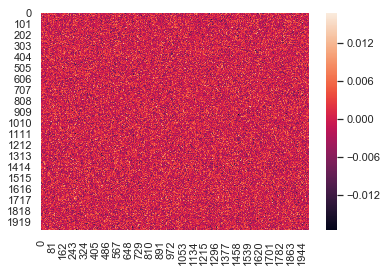

In [19]:
# random A with np lib function
m,n,k = 2000,2000,120
randU = np.random.rand(m,m)
randV = np.random.rand(n,n)
randU, r = np.linalg.qr(randU)
randV, r = np.linalg.qr(randV)
sig = np.random.choice(100, k)/100
sig = np.asarray(sig.tolist() + (np.zeros(m-k)).tolist())
P = np.diag(sig)
A = np.matmul(randU,P)
A = np.matmul(A,randV)
print(A)

import seaborn as sns; sns.set()
ax = sns.heatmap(A)

# rsvd implementation in python

* Step1: compute $Q$  used in $A\approx Q Q^T A = QB$
    0. Preprocess $A$ to $A^{(q)} := (AA^T)^{(q)}A$
    1. Generate Random Matrix $\Omega$
    2. Apply QR-decomp to $Y:=A\Omega = QR$

In [23]:
# Generate Random Matrix Omega(nxk)
q = 2 # Preprocessing (page 9 of the write up of rsvd) for better computation, applied later with Y
k = 30 # How many random vectors you want to use -> changes the size of Omega.
p = 10 # OverSampling
l = k+p # l is lowercase L
Omega = []
for i in list(range(0,l)):
    w = (np.random.choice(int(n/10),n))/100 # n is the column number of A
    Omega.append(w)
print(Omega) # Omega is a collection of k+p random vectors
Omega = np.column_stack(Omega) # Merge all k+p vectors into a matrix Omega.
print(Omega)

[array([1.56, 1.56, 1.1 , ..., 1.19, 0.48, 1.13]), array([0.  , 0.4 , 1.88, ..., 1.93, 0.17, 0.83]), array([0.51, 1.47, 1.32, ..., 1.66, 1.31, 1.96]), array([1.4 , 1.77, 1.16, ..., 1.82, 1.2 , 1.59]), array([0.34, 1.12, 1.49, ..., 0.59, 1.89, 0.75]), array([0.44, 0.97, 1.78, ..., 0.36, 1.76, 1.42]), array([0.12, 0.97, 1.42, ..., 0.8 , 0.6 , 0.43]), array([0.97, 0.62, 1.73, ..., 1.24, 1.42, 0.35]), array([1.76, 1.47, 1.76, ..., 1.55, 0.03, 1.47]), array([1.64, 0.03, 1.76, ..., 1.76, 1.5 , 1.02]), array([1.29, 1.84, 0.76, ..., 0.71, 0.97, 0.21]), array([1.95, 0.25, 1.1 , ..., 1.77, 0.33, 0.8 ]), array([0.38, 0.95, 0.22, ..., 1.21, 0.17, 1.39]), array([1.19, 1.24, 0.38, ..., 0.98, 0.31, 0.59]), array([0.72, 1.76, 0.94, ..., 0.43, 0.79, 0.96]), array([0.71, 0.14, 1.54, ..., 0.59, 1.88, 1.46]), array([1.73, 0.55, 0.99, ..., 0.41, 0.49, 0.25]), array([0.24, 1.17, 0.26, ..., 0.99, 0.2 , 1.47]), array([0.28, 0.76, 1.27, ..., 0.86, 0.17, 1.35]), array([1.74, 0.86, 0.39, ..., 1.96, 1.42, 0.56]),

In [24]:
# Apply QR-decomp to A*Omega with preprocess amount q (refer to page 9 in the write up by Erichson)
Y = np.matmul(A,Omega)
for i in list(range(0,q)):
    Q, R = np.linalg.qr(Y)
    Q, R = np.linalg.qr(np.matmul(np.transpose(A), Q))
    Y = np.matmul(A,Q)
Q, R = np.linalg.qr(Y)

* Step2: $A \approx QQ^{T}A = QB = Q\hat{U}\Sigma V^{T} = U\Sigma V^{T}$

In [25]:
# Apply traditional svd on B and gain approx svd for A
B = np.matmul(np.transpose(Q),A)
U_hat, S, V_t = np.linalg.svd(B)
U = np.matmul(Q,U_hat)
# Now svd for A is approximately U, S, V_t

* Now, we can calculate true svd and compare.

In [26]:
# True SVD of A
U2,S2,V2 = np.linalg.svd(A)

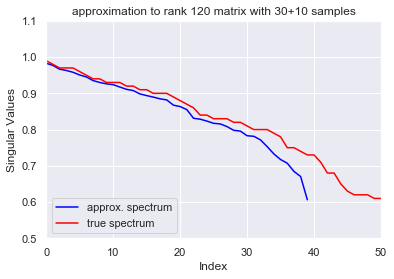

In [42]:
plt.plot(S,color = "blue",label='approx. spectrum')
plt.plot(S2,color="red",label='true spectrum')
plt.xlim(0,50)
plt.ylim(0.5,1.1)
plt.title("approximation to rank 120 matrix with 30+10 samples")
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.legend(loc='lower left')
plt.show()

In [35]:
# Difference in size of the approximated spectrum and the true spectrum. It is very small.
concS2 = S2[:40]
diff = np.linalg.norm(concS2-S)
print(diff)

0.2089792330434948


* Below is the function version of rsvd
    * Keep the default parameters in mind

In [44]:
# @A input matrix
# @q preprocessing amount
# @k sample amount
# @p oversample amount
def rsvd(A,q=2,k=30,p=10):
    l = k+p
    Omega = []
    for i in list(range(0,l)):
        w = (np.random.choice(int(n/10),n))/100
        Omega.append(w)
    Omega = np.column_stack(Omega)
    Y = np.matmul(A,Omega)
    for i in list(range(0,q)):
        Q, R = np.linalg.qr(Y)
        Q, R = np.linalg.qr(np.matmul(np.transpose(A), Q))
        Y = np.matmul(A,Q)
    Q, R = np.linalg.qr(Y)
    B = np.matmul(np.transpose(Q),A)
    U_hat, S, V_t = np.linalg.svd(B)
    U = np.matmul(Q,U_hat)
    return U, S, V_t

# Diverse Insights

1. Power of Preprocessing
    * Decay in spectrum for preprocessed and non-preprocessed matrices (page 8 of rsvd write up by Erichson)
    * The result evidently shows that the decay gets faster with preprocessing.
    * This means that the data A becomes better for approximating

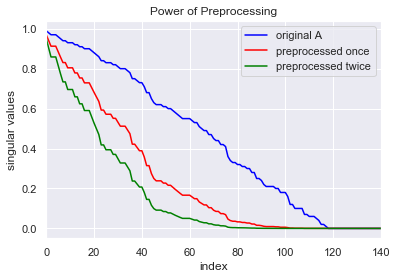

In [41]:
# True Spectrum vs Preprocessed Spectrum
U2,S2,V2 = np.linalg.svd(A)
AAT = np.matmul(A,np.transpose(A))
A_1 = np.matmul(AAT,A)
U3,S3,V3 = np.linalg.svd(A_1)
A_2 = np.matmul(AAT,A_1)
U4,S4,V4 = np.linalg.svd(A_2)

plt.plot(S2,color = "blue",label='original A')
plt.plot(S3,color="red",label='preprocessed once')
plt.plot(S4,color="green", label='preprocessed twice')
plt.title('Power of Preprocessing')
plt.xlim(0,140)
plt.xlabel('index')
plt.ylabel('singular values')
plt.legend(loc='upper right')
plt.show()

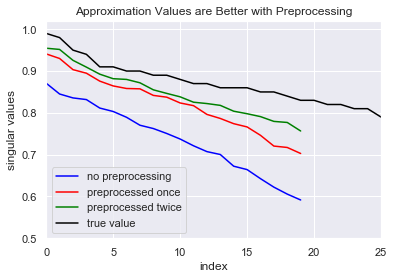

In [84]:
# p is a place holder here
p,s1,p = rsvd(A,q=0,k=10)
p,s2,p = rsvd(A,q=1,k=10)
p,s3,p = rsvd(A,q=2,k=10)
p,s4,p = np.linalg.svd(A)
plt.plot(s1,color="blue",label='no preprocessing')
plt.plot(s2,color="red",label='preprocessed once')
plt.plot(s3,color="green",label='preprocessed twice')
plt.plot(s4,color="black", label='true value')
plt.xlim(0,25)
plt.ylim(0.5, 1.02)
plt.title('Approximation Values are Better with Preprocessing')
plt.xlabel('index')
plt.ylabel('singular values')
plt.legend(loc='lower left')
plt.show()

2. Sampling amount and Oversampling
    * More sampling means more stable
    * Oversampling by few more helps a lot

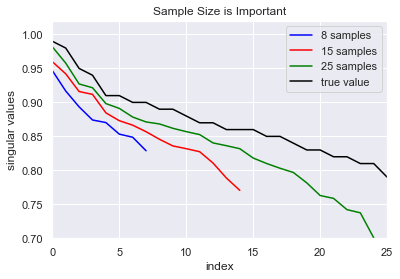

In [82]:
# p is a place holder here. set oversampling to 0
p,s1,p = rsvd(A,k=8,p=0)
p,s2,p = rsvd(A,k=15,p=0)
p,s3,p = rsvd(A,k=25,p=0)
#p,s4,p = np.linalg.svd(A) #calculated from before
plt.plot(s1,color="blue",label='8 samples')
plt.plot(s2,color="red",label='15 samples')
plt.plot(s3,color="green",label='25 samples')
plt.plot(s4,color="black", label='true value')
plt.xlim(0,25)
plt.ylim(0.7,1.02)
plt.title('Sample Size is Important')
plt.xlabel('index')
plt.ylabel('singular values')
plt.legend(loc='upper right')
plt.show()

3. Sparsity of a Matrix

4. Spectral Decay of a Matrix

# Time Comparison

In [82]:
import time

In [87]:
#### normal svd

start = time.time()
U2,S2,V2 = np.linalg.svd(A)
end = time.time()

print(end-start)

3.61962890625


In [86]:
#### rsvd with q=2 k=30 => 10 times faster than normal svd

start = time.time()
u,s,v = rsvd(A,q=2,k=30)
end = time.time()

print(end-start)

0.377500057220459


# Consideration & Discussion

* Difference in Computing for rapid decaying spectrum and slow decaying spectrum
* Difference in Computing for Sparsity of a Matrix